In [2]:
import json
import random
import re

import ee

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from landdegradation.util import get_coords
from landdegradation.schemas.schemas import TimeSeries, TimeSeriesTable, TimeSeriesTableSchema

# The service account email address authorized by your Google contact.
# Set up a service account as described in the README.
EE_ACCOUNT = 'gef-ldmp-server@gef-ld-toolbox.iam.gserviceaccount.com'

# The private key associated with your service account in JSON format.
EE_PRIVATE_KEY_FILE = 'D:/Code/LandDegradation/decisiontheater/te_key.json'

EE_CREDENTIALS = ee.ServiceAccountCredentials(EE_ACCOUNT, EE_PRIVATE_KEY_FILE)
#ee.Initialize(EE_CREDENTIALS)
ee.Initialize()

# Dictionary to remap from ESA CCI to 7 classes
remap_dict = {'0': '0',
              '50': '1',
              '60': '1',
              '61': '1',
              '62': '1',
              '70': '1',
              '71': '1',
              '72': '1',
              '80': '1',
              '81': '1',
              '82': '1',
              '90': '1',
              '100': '1',
              '160': '1',
              '170': '4',
              '110': '2',
              '120': '2',
              '121': '2',
              '122': '2',
              '130': '2',
              '140': '2',
              '150': '2',
              '151': '2',
              '152': '2',
              '153': '2',
              '40': '2',
              '10': '3',
              '11': '3',
              '12': '3',
              '20': '3',
              '30': '3',
              '180': '4',
              '190': '5',
              '200': '6',
              '201': '6',
              '202': '6',
              '220': '6',
              '210': '7'}
remap_dict = {0: 0,
              50: 1,
              60: 1,
              61: 1,
              62: 1,
              70: 1,
              71: 1,
              72: 1,
              80: 1,
              81: 1,
              82: 1,
              90: 1,
              100: 1,
              160: 1,
              170: 4,
              110: 2,
              120: 2,
              121: 2,
              122: 2,
              130: 2,
              140: 2,
              150: 2,
              151: 2,
              152: 2,
              153: 2,
              40: 2,
              10: 3,
              11: 3,
              12: 3,
              20: 3,
              30: 3,
              180: 4,
              190: 5,
              200: 6,
              201: 6,
              202: 6,
              220: 6,
              210: 7}

# Class names and color codes
classes = pd.DataFrame(data={'Label': ["No data", "Forest", "Grassland", "Cropland",
                                       "Wetland", "Artificial", "Bare", "Water"],
                             'Code' : [0, 1, 2, 3, 4, 5, 6, 7],
                             'Color' : ["#000000", "#787F1B", "#FFAC42", "#FFFB6E",
                                        "#00DB84", "#E60017", "#FFF3D7", "#0053C4"]})

In [41]:
def get_plot_data(year_start, year_end, geojsons):
    # geospatial datasets 
    lcover = "users/geflanddegradation/toolbox_datasets/lcov_esacc_1992_2018"
    vegindex = "users/geflanddegradation/toolbox_datasets/ndvi_modis_2001_2019"
    precip = "users/geflanddegradation/toolbox_datasets/prec_chirps_1981_2019"
    
    region = ee.Geometry(geojsons)

    # sets time series of interest
    lcov = ee.Image(lcover).select(ee.List.sequence(year_start - 1992, 26, 1))    
    ndvi = ee.Image(vegindex).select(ee.List.sequence(year_start - 2001, year_end - 2001, 1))
    prec = ee.Image(precip).select(ee.List.sequence(year_start - 1981, year_end - 1981, 1))

    # retrieves value of the pixel that intesects coord_point
    values_lcov = lcov.reduceRegion(ee.Reducer.toList(), region, 1)
    values_ndvi = ndvi.reduceRegion(ee.Reducer.toList(), region, 1)
    values_prec = prec.reduceRegion(ee.Reducer.toList(), region, 1)

    res = {'land_cover': values_lcov.getInfo(),
           'ndvi': values_ndvi.getInfo(),
           'precipitation': values_prec.getInfo()}
    ts = []
    for key in res.keys():   
        d = list((int(k.replace('y', '')), int(v[0])) for k, v in res[key].items())
        # Ensure the data is chronological
        d = sorted(d, key=lambda x: x[0]) 
        years = list(x[0] for x in d)
        data = list(x[1] for x in d)
        ts.append(pd.DataFrame(data={key: data}, index=years))
    
    # Join all the timeseries pandas dataframes together
    out = ts[0]
    for this_ts in ts[1:]:
        out = out.join(this_ts, how='outer')
    
    # Recode the ESA codes to IPCC 7 classes
    for n in range(len(out.index)):
        esa_code = out.land_cover.iloc[n]
        if not np.isnan(esa_code):
            out.land_cover.iloc[n] = remap_dict[esa_code]
        
    return out


def make_plot(d):
    # Make plot
    fig = plt.figure(constrained_layout=False, figsize=(15, 11.28), dpi=100)
    #fig.patch.set_facecolor('white')
    spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig,
                             height_ratios=[3, 3, 1], hspace=0)

    axs = []
    for row in range(3):
        axs.append(fig.add_subplot(spec[row, 0]))

    # Fake having all seven classes show up
    #d.land_cover.iloc[0] = 0
    #d.land_cover.iloc[1] = 1
    #d.land_cover.iloc[2] = 2
    #d.land_cover.iloc[3] = 3
    #d.land_cover.iloc[4] = 4
    #d.land_cover.iloc[5] = 5
    #d.land_cover.iloc[6] = 6
    #d.land_cover.iloc[7] = 7
    
    # Account for scaling on NDVI
    d.ndvi = d.ndvi / 10000

    axs[0].plot(d.index, d.ndvi, color='#0B6623', linewidth=3)
    axs[0].set_xlim(year_start, year_end)
    axs[0].set_ylim(d.ndvi.min() * .95, d.ndvi.max() * 1.1)
    axs[0].set_ylabel('NDVI\n(annual)', fontsize=32)
    axs[0].tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True, labelsize=28)
    axs[0].tick_params(axis='x', bottom=False, labelbottom=False)

    axs[1].plot(d.index, d.precipitation, color='#1167b1', linewidth=3)
    axs[1].set_xlim(year_start, year_end)
    axs[1].set_ylabel('Precipitation\n(annual, mm)', fontsize=32)
    axs[1].tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True, labelsize=28)
    axs[1].tick_params(axis='x', bottom=False, labelbottom=False)

    for n in range(len(d.index)):
        if not np.isnan(d.land_cover.iloc[n]):
            axs[2].fill_between([d.index[n], d.index[n] + 1],
                                [0, 0], [1, 1],
                                color=classes.Color.iloc[int(d.land_cover.iloc[n])],
                                label=classes.Label.iloc[int(d.land_cover.iloc[n])])
    axs[2].set_xlim(year_start, year_end)
    axs[2].set_ylim(0, 5)
    axs[2].tick_params(axis='y', left=False, labelleft=False, labelsize=28)
    axs[2].tick_params(axis='x', labelsize=28)
    axs[2].set_xlabel('Year', fontsize=32)
    axs[2].set_ylabel('Land\nCover', fontsize=32)
    handles, labels = axs[2].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[2].legend(by_label.values(), by_label.keys(), ncol=4, frameon=False, fontsize=26, borderpad=0)

    im = Image.open('trends_earth_logo_bl_print.png')
    height = im.size[1]
    # We need a float array between 0-1, rather than
    # a uint8 array between 0-255
    im = np.array(im).astype(np.float) / 255
    fig.figimage(im, 120, fig.bbox.ymax - height-30, zorder=-1)
    
    # Set the first axis background to transparent so the trends.earth logo (placed behind it) will show through
    axs[0].patch.set_facecolor('w')
    axs[0].patch.set_alpha(0)
    
    return plt

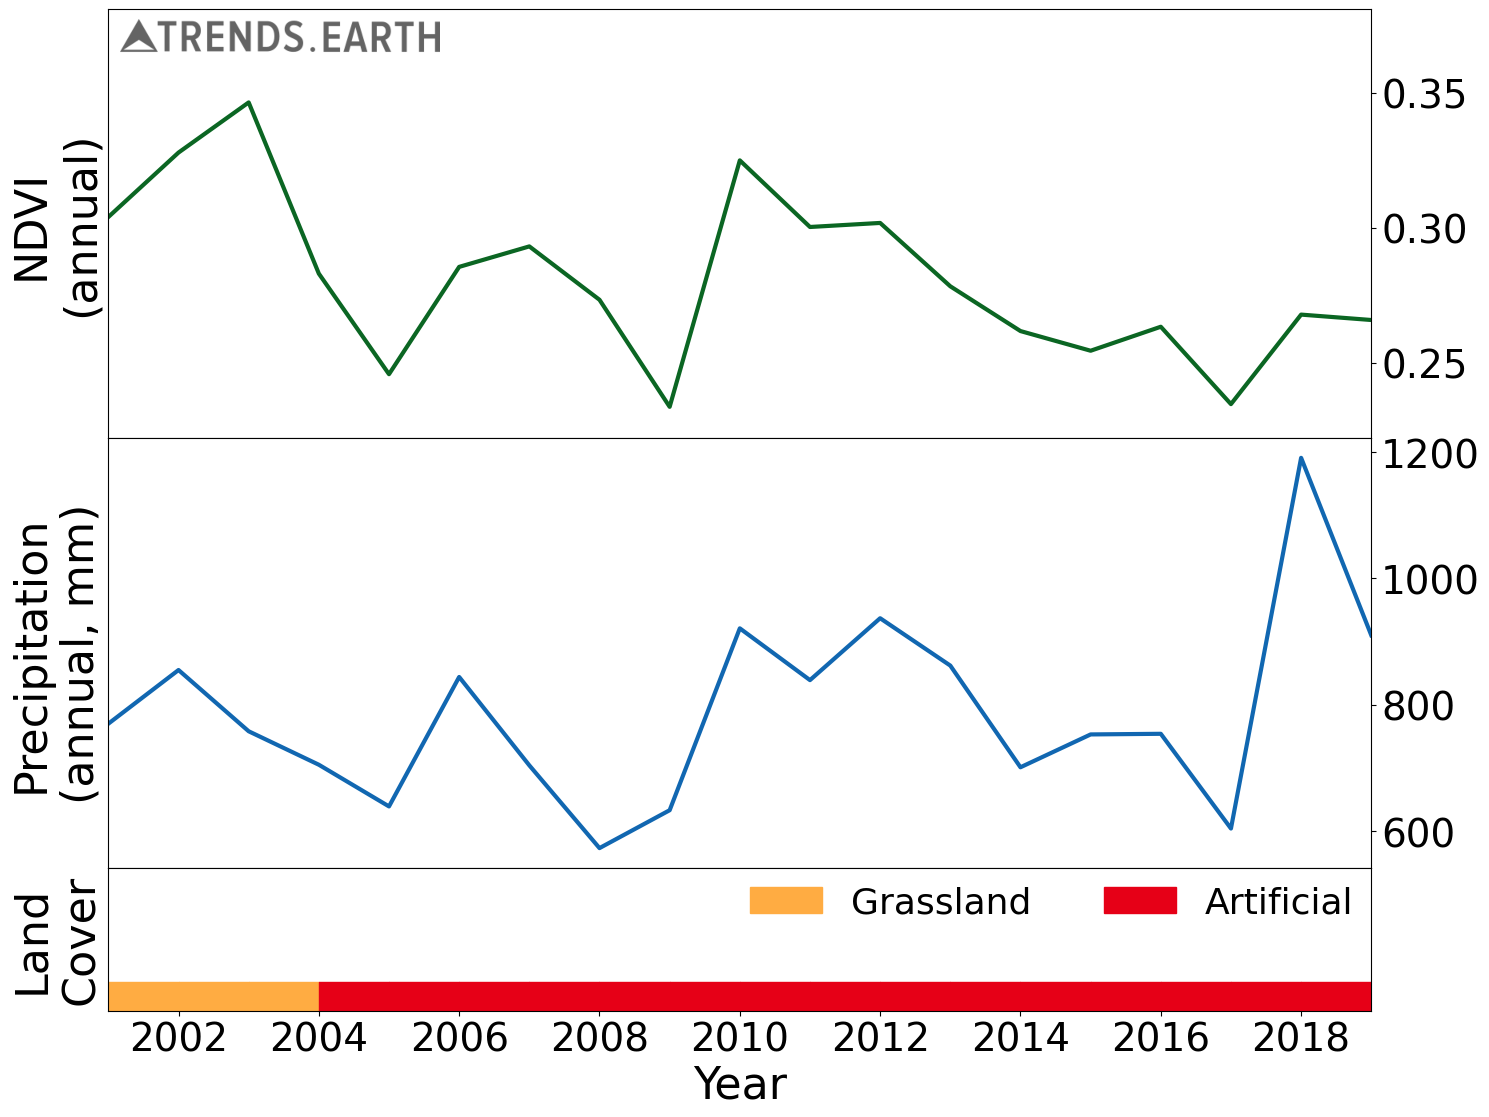

In [43]:
# Pull data
year_start = 2001
year_end = 2019
geojson = json.loads("""{\"coordinates\": [36.43006146, -0.71011347], \"type\": \"Point\"}""")
crs = """GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]]"""
res = get_plot_data(year_start, year_end, geojson)

pd.options.mode.chained_assignment = None  # default='warn'
plt = make_plot(res)
plt.tight_layout()
plt.savefig('landtrend_plt.png', bbox_inches='tight')
plt.show()